# Ensembles -- boosting

Aula baseada em: http://www.cs.cmu.edu/~aarti/Class/10601/slides/boosting_11_29_2011.pdf e https://xavierbourretsicotte.github.io/AdaBoost.html

Em sala de aula, vimos todas as principais famílias de ensembles, desde combinadores simples como votação até métodos sofisticados como stacking, bagging (com detaque para RandomForest) e boosting. Nesta aula, vamos nos aprofundar um pouco mais em uma técnica clássica de boosting, o AdaBoost, e discutir rapidamente algumas implicações do que estamos fazendo no contexto mais geral de aprendizagem de máquina.

In [1]:
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style('white')

%matplotlib inline

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = None, ax = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    if scatter_weights is None:
        scatter_weights = np.ones(len(y))
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    
    #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 300)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

## AdaBoost

Suponha que temos $m$ classificadores fracos $M_j(X)$, $j = 1..m$ e queremos classificar $N$ instâncias. Nosso objetivo é conseguir um classificador global que corresponde à soma ponderada dos vários classificadores fracos. Supondo que cada classificador é binário e retorna um valor -1 ou +1 conforme sua decisão, $G$ é descrito como:

$$
G(X) = sinal(\alpha_1 M_1(X) + \alpha_2 M_2(X) + ... + \alpha_m M_m(X))
$$

onde os pesos $\alpha_j$ são obtidos pelo algoritmo de boosting de acordo com os erros cometidos por cada modelo $M_j$ e $sinal(f)$ é +1 se $f > 0$ e -1 se $f < 0$.

A ideia geral do algoritmo é que em cada passo de sua iteração (ou seja, cada modelo construído), pesos $w_1,w_2,...,w_N$ são modificados de forma que as instâncias incorretamente classificadas pelo modelo $M_j$ são mais importantes para o modelo $M_{j+1}$. Na primeira iteração, todas as $N$ instâncias são igualmente importantes, ou seja, tem peso $w_i=1/N$.

O Algoritmo AdaBoost pode ser descrito como segue em termos gerais:

* Taxa de aprendizado $\gamma = 0.5$
* Inicie os pesos das instâncias como $w_i=1/N$
* para $j = 1,2,...,m$
    * Obtenha $\hat{y} = M_j(X)$
    * Calcule o erro ponderado do modelo, $erro_j = \sum^{N}_{i=1} w_i {\bf 1}(y_i \ne \hat{y}_i)$ 
    * Compute o peso $\alpha_j=\gamma \log(\frac{1−erro_j}{erro_j})$
    * Defina pesos $w_i \leftarrow \eta~w_i e^{-\alpha_j y_i \hat{y}_i}$, $\eta$ é uma constante de normalização 
* retorne $G(X) = sinal(\sum^m_{j=1} \alpha_j M_j(X))$

Como $erro_j$ só pode assumir valores entre 0 e 1, o peso $\alpha_j$ dos modelos pode variar de 0 a infinito. Desta forma, os pesos $w_i$ das instâncias são atualizados conforme abaixo, ao considerarmos os pesos $\alpha_j$ dos modelos, variando de 0 a 2:

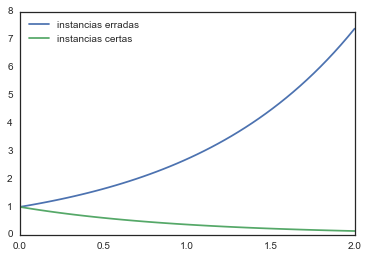

In [3]:
alpha = np.linspace(0,2,50)
plt.plot(alpha, np.exp(alpha), label='instancias erradas')
plt.plot(alpha, np.exp(-alpha), label='instancias certas')
plt.legend(loc = 'upper left')

Ou seja, o peso das instâncias erradas cresce exponencialmente conforme o peso do modelo. Ao, contrário, o peso das instâncias certas decresce lentamente. 

Vejamos esse algoritmo passo a passo com o exemplo abaixo:

In [4]:
data = pd.DataFrame({'x1': [1, 2, 3, 4, 5, 7, 7, 8, 9, 9], 
                     'x2': [4, 2, 1, 5, 7, 4, 8, 6, 2, 7], 
                     'y':[1, 1, -1, -1, 1, -1, 1, 1, -1, -1]})

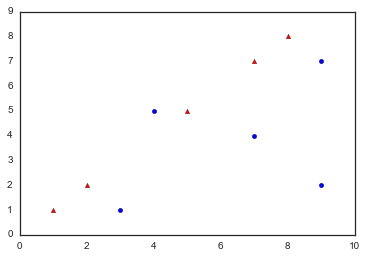

In [5]:
plt.scatter(data.x1[data.y == -1], data.x2[data.y == -1], marker = 'o', c = 'blue')
plt.scatter(data.x1[data.y == 1], data.x1[data.y == 1], marker = '^', c = 'red')

Para cada modelo, vamos salvar tanto as decisões $\hat{y}_i$ dos modelos quanto seus pesos $\alpha_i$:

In [6]:
yhats = []
alphas = []

Vamos usar como classificador fraco $M_j$ uma árvore de decisão com profundidade = 1, ou seja, apenas o corte na raíz.

In [7]:
from sklearn.tree import DecisionTreeClassifier
stump = DecisionTreeClassifier(max_depth = 1)

### Primeira iteração: $M_1$

Como descrito, vamos começar com pesos uniformes para as instâncias, ou seja, $w_i=1/N$.

In [8]:
N = data.shape[0]
data['wi'] = 1/N
data

,x1,x2,y,wi
0,1,4,1,0.1
1,2,2,1,0.1
2,3,1,-1,0.1
3,4,5,-1,0.1
4,5,7,1,0.1
5,7,4,-1,0.1
6,7,8,1,0.1
7,8,6,1,0.1
8,9,2,-1,0.1
9,9,7,-1,0.1


In [9]:
X = data[['x1', 'x2']].values
y = data.y.values

In [10]:
stump.fit(X, y, sample_weight = data.wi.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
data['yhat'] = stump.predict(X)
yhats.append(data['yhat'].copy().values)

In [12]:
data

,x1,x2,y,wi,yhat
0,1,4,1,0.1,1
1,2,2,1,0.1,1
2,3,1,-1,0.1,-1
3,4,5,-1,0.1,-1
4,5,7,1,0.1,-1
5,7,4,-1,0.1,-1
6,7,8,1,0.1,-1
7,8,6,1,0.1,-1
8,9,2,-1,0.1,-1
9,9,7,-1,0.1,-1


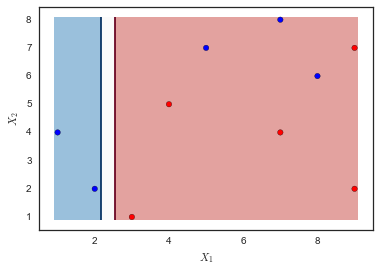

In [14]:
plot_decision_boundary(stump, X, y, scatter_weights = data.wi.values)

Cálculo do erro ponderado do modelo, $erro_j = \sum^{N}_{i=1} w_i {\bf 1}(y_i \ne \hat{y}_i)$ :

In [15]:
# erros
erro = data.wi.values[data.yhat != y].sum()
erro

0.30000000000000004

Cálculo de peso $\alpha_j=\gamma \log(\frac{1−erro_j}{erro_j})$ e pesos $w_i \leftarrow \eta~w_i e^{-\alpha_j y_i \hat{y}_i}$, $\eta$ é uma constante de normalização:

In [16]:
learning_rate = 0.5

In [17]:
alphaj = learning_rate * np.log((1. - erro) / erro)
alphas += [alphaj]

data['wi'] = data.apply(lambda r: r.wi * np.exp(- alphaj * r.y * r.yhat), axis = 1)
# normalize
data['wi'] = data.wi / data.wi.sum() 

alphaj

0.4236489301936017

### Segunda iteração: modelo 2

In [18]:
X = data[['x1', 'x2']].values
y = data.y.values

In [19]:
stump.fit(X, y, sample_weight = data.wi.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [20]:
data['yhat'] = stump.predict(X)
yhats.append(data['yhat'].copy().values)

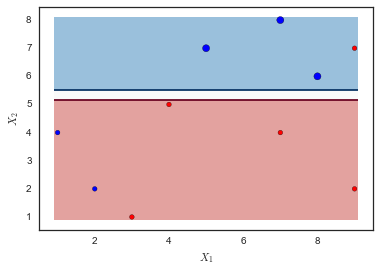

In [21]:
plot_decision_boundary(stump, X, y, scatter_weights = data.wi.values)

In [22]:
# erros
erro = data.wi.values[data.yhat != y].sum()
erro

0.2142857142857143

In [23]:
alphaj = learning_rate * np.log((1. - erro) / erro)
alphas += [alphaj]

data['wi'] = data.apply(lambda r: r.wi * np.exp(- alphaj * r.y * r.yhat), axis = 1)
# normalize
data['wi'] = data.wi / data.wi.sum() 

alphaj

0.6496414920651304

In [24]:
data

,x1,x2,y,wi,yhat
0,1,4,1,0.166667,-1
1,2,2,1,0.166667,-1
2,3,1,-1,0.045455,-1
3,4,5,-1,0.045455,-1
4,5,7,1,0.106061,1
5,7,4,-1,0.045455,-1
6,7,8,1,0.106061,1
7,8,6,1,0.106061,1
8,9,2,-1,0.045455,-1
9,9,7,-1,0.166667,1


### Terceira iteração: modelo 3

In [25]:
X = data[['x1', 'x2']].values
y = data.y.values

In [26]:
stump.fit(X, y, sample_weight = data.wi.values)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [27]:
data['yhat'] = stump.predict(X)
yhats.append(data['yhat'].copy().values)

In [28]:
data

,x1,x2,y,wi,yhat
0,1,4,1,0.166667,1
1,2,2,1,0.166667,1
2,3,1,-1,0.045455,1
3,4,5,-1,0.045455,1
4,5,7,1,0.106061,1
5,7,4,-1,0.045455,1
6,7,8,1,0.106061,1
7,8,6,1,0.106061,1
8,9,2,-1,0.045455,-1
9,9,7,-1,0.166667,-1


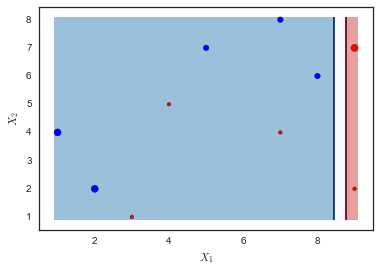

In [29]:
plot_decision_boundary(stump, X, y, scatter_weights = data.wi.values)

In [30]:
# erros
erro = data.wi.values[data.yhat != y].sum()
erro

0.1363636363636364

In [31]:
alphaj = learning_rate * np.log((1. - erro) / erro)
alphas += [alphaj]

data['wi'] = data.apply(lambda r: r.wi * np.exp(- alphaj * r.y * r.yhat), axis = 1)
# normalize
data['wi'] = data.wi / data.wi.sum() 

alphaj

0.9229133452491651

In [32]:
data

,x1,x2,y,wi,yhat
0,1,4,1,0.096491,1
1,2,2,1,0.096491,1
2,3,1,-1,0.166667,1
3,4,5,-1,0.166667,1
4,5,7,1,0.061404,1
5,7,4,-1,0.166667,1
6,7,8,1,0.061404,1
7,8,6,1,0.061404,1
8,9,2,-1,0.026316,-1
9,9,7,-1,0.096491,-1


### Combinando modelos

Uma vez que temos os vários modelos, podemos combiná-los como uma votação ponderada dos votos -1 e +1. Se essa soma for menor que 0, então a classe final escolhida é -1, caso contrário é +1: 

$G(X) = sinal(\sum^m_{j=1} \alpha_j M_j(X))$

In [33]:
yhats = np.asarray(yhats)
alphas = np.asarray(alphas)
yhats, alphas

(array([[ 1,  1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
        [ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1]]),
 array([0.42364893, 0.64964149, 0.92291335]))

In [34]:
c_yhats = np.array([np.sign((yhats[:,i]*alphas).sum()) for i in range(10)])
c_yhats

array([ 1.,  1., -1., -1.,  1., -1.,  1.,  1., -1., -1.])

In [35]:
y

array([ 1,  1, -1, -1,  1, -1,  1,  1, -1, -1])

Observe que nossa decisão final: 

$G(X) = sinal(\sum^m_{j=1} \alpha_j M_j(X))$

é uma superfície de decisão onde os pesos são $\alpha_j$ e as entradas são transformações $M_j$ dos atributos originais $X$. Assim, os eixos são funções de $X$. O Adaboost é, portanto, uma busca de uma superfície em um espaço de funções.  

<img src="Boosting.png" style="height:300px">

Neste sentido, o AdaBoost tem muito em comum com os SVMs não lineares, com a diferença que os transformadores usados são funções que, nelas mesmas, também já tinham sido criadas para encontrar superfícies de decisão no espaço orginal. Lembre que as funções de kernel do SVM são escolhas a priori que temos a esperança de levar a um espaço onde o problema possa ser linearmente separável, mas as funções em si não foram projetadas especificamente para garantir isso, a não ser pelo fato de terem alta dimensionalidade. 

Isto apenas reforça a ideia de que uma solução mais apropriada para o problema que estamos tentando resolver pode ser obtida em uma nova representação do espaço original. Note que esta ideia pode ser aplicada recursivamente (boosting de boosting, níveis ou camadas de representação). Até os anos 2000, contudo, não havia muita expectativa que sucessivas transformações no espaço pudessem levar a ganhos crescentes dada a crescente complexidade dos modelos resultantes e, naturalmente, os inevitáveis problemas com _overfitting_.  

Apenas algumas observações finais:

* Métodos de boosting tendem a dar ganho maior quando usados com weak learners (em relação a um baseline weak learner), ou seja, classificadores apenas melhores que métodos puramente aleatórios. Exemplos de weak learners são árvores com profundidade 1, o algoritmo OneR, etc.
* Métodos de boosting dão muito ganho quando o learner usado é instável como métodos de árvores (métodos instáveis são aqueles que, para pequenas mudanças no treino, podemos observar grandes mudanças nos modelos).